<a href="https://colab.research.google.com/github/zcvpal2/Aiffel-follow-deep-learning/blob/main/aiffle_7_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EA%BD%83%EA%B8%B8%EB%A7%8C_%EA%B1%B7%EC%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## tfds.load를 활용해서 데이터셋 내려받기

import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

DATA_DIR = '/content/drive/MyDrive/AIFFEL/flowers'

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir = DATA_DIR,
    with_info = True,
    as_supervised = True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /content/drive/MyDrive/AIFFEL/flowers/tf_flowers/3.0.1. Subsequent calls will reuse this data.


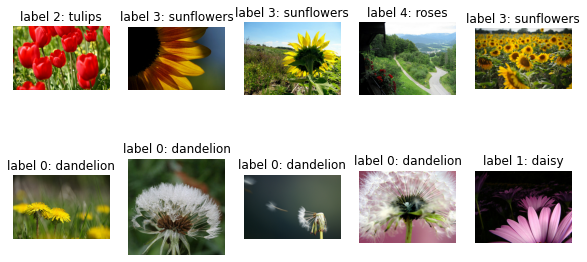

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackedn.figure_format = 'retina'

plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
  plt.subplot(2, 5, idx+1)
  plt.imshow(image)
  plt.title(f'label {label}: {get_label_name(label)}')
  plt.axis('off')

In [4]:
## 모두 같은 크기로 만들어야 하니까
IMG_SIZE = 160 

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# train, validation, test를 각각 규격에 맞게 변경

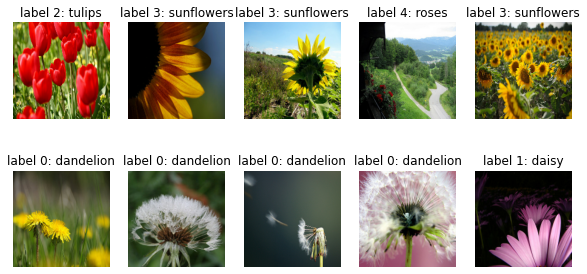

In [6]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

# 규격에 맞게 변한 train 데이터를 한 번 10개만 뽑아서 확인
for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [8]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# VGG16을 베이스 모델로 설정하여 학습을 시킨다. 
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                        include_top = False, 
                                        weights = 'imagenet')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(256, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
## base 모델은 학습시키면 안되기 때문에 False를 적용
base_model.trainalbe = False

In [10]:
## 최종 모델 설정
model = Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [11]:
## 모델 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,847,301
Trainable params: 14,847,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
## 모델 학습시키기 (epoch, learning_late, optimizer)

learning_rate = 0.001

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate),
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['accuracy'])

In [13]:
## 한스텝에 학습시킬 데이터 개수 batch와 데이터를 섞어줄 shuffle을 설정

BATCH_SIZE = 32
SHUFFLE = 1000

In [14]:
## 셔플만큼 셔플해주고, 배치 사이즈 만큼 배치 해라
train_batches = train.shuffle(SHUFFLE).batch(BATCH_SIZE)
validation_batches =  validation.shuffle(SHUFFLE).batch(BATCH_SIZE)
test_batches = test.shuffle(SHUFFLE).batch(BATCH_SIZE)

In [15]:
## 모델 학습
EPOCHS = 10
history = model.fit(train_batches,
epochs=EPOCHS,
validation_data=validation_batches)


Epoch 1/10
92/92 [==============================] - 47s 305ms/step - loss: 4146.4004 - accuracy: 0.2755 - val_loss: 1.6159 - val_accuracy: 0.2752
Epoch 2/10
92/92 [==============================] - 23s 242ms/step - loss: 1.7476 - accuracy: 0.2681 - val_loss: 2.4869 - val_accuracy: 0.1689
Epoch 3/10
92/92 [==============================] - 23s 242ms/step - loss: 1.7265 - accuracy: 0.2527 - val_loss: 6.0086 - val_accuracy: 0.2752
Epoch 4/10
92/92 [==============================] - 23s 241ms/step - loss: 1.7638 - accuracy: 0.2619 - val_loss: 1.6015 - val_accuracy: 0.2425
Epoch 5/10
92/92 [==============================] - 23s 242ms/step - loss: 1.6324 - accuracy: 0.2708 - val_loss: 1.4940 - val_accuracy: 0.4332
Epoch 6/10
92/92 [==============================] - 23s 241ms/step - loss: 1.6176 - accuracy: 0.2861 - val_loss: 1.4059 - val_accuracy: 0.4414
Epoch 7/10
92/92 [==============================] - 23s 243ms/step - loss: 1.5123 - accuracy: 0.3450 - val_loss: 1.3953 - val_accuracy: 0.4

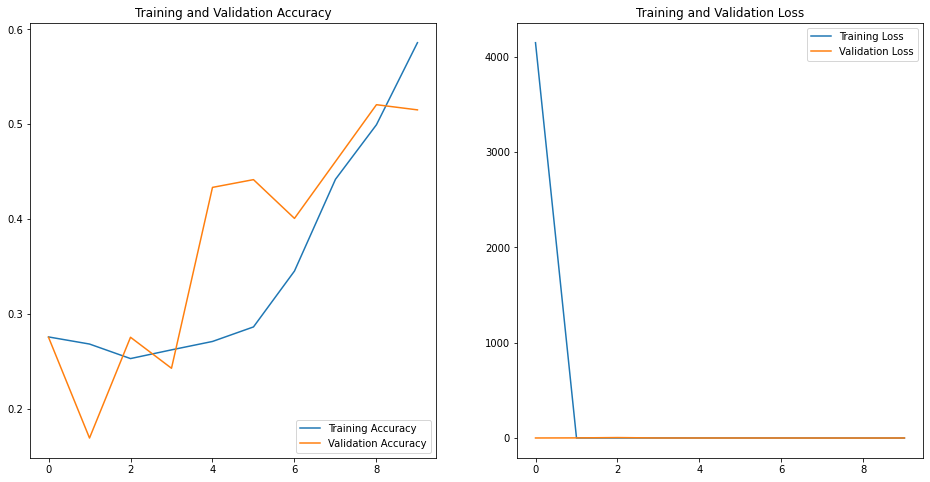

In [16]:
## 모델 성능 평가하기

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
## test에 대한 예측 > steps 만큼 예측하고 평균 내어 구해진다

steps =10 
loss0, accuracy0 = model.evaluate(test_batches, steps = steps)
## loss와 accuracy를 말해줘 모델을 평가해서, 테스트 배치 모델을 10개만큼

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 2s 87ms/step - loss: 1.7920 - accuracy: 0.4594
initial loss: 1.79
initial accuracy: 0.46


In [18]:
## 이제 활용해보자 원하는 이미지 넣고 예측시키게
import numpy as np

for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)
predictions

array([0, 2, 1, 1, 1, 1, 1, 1, 4, 4, 1, 2, 1, 1, 1, 0, 4, 1, 1, 0, 1, 4,
       1, 1, 1, 1, 0, 1, 1, 2, 1, 1])

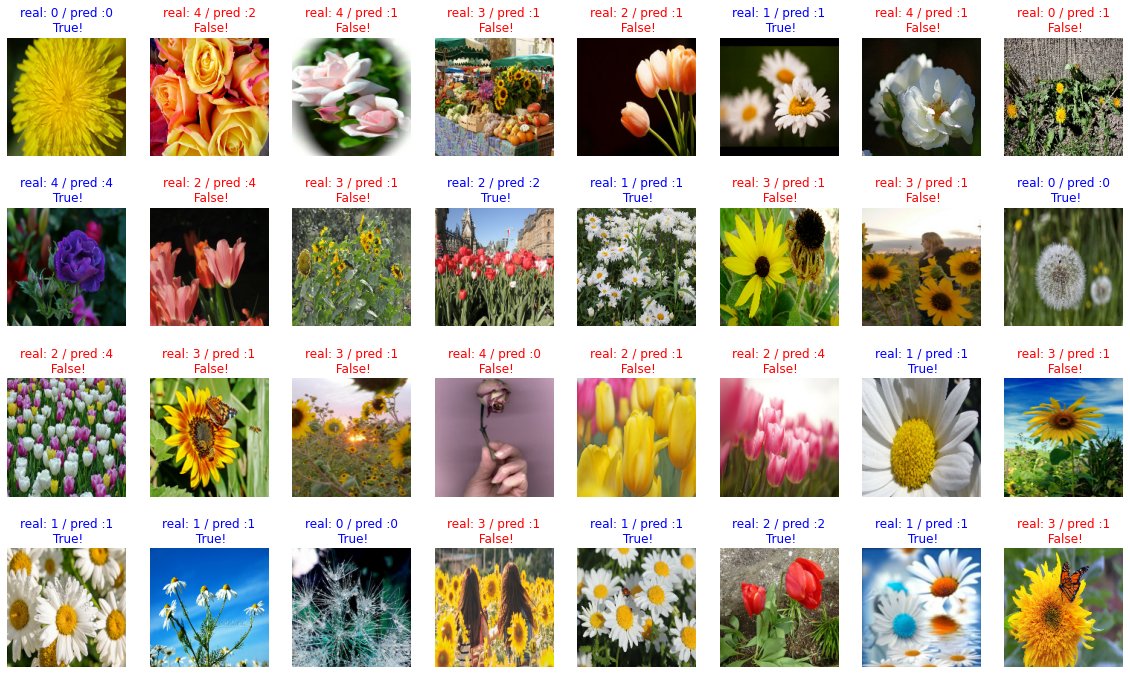

In [19]:
## 최종 시각화
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')